In [1]:
%load_ext autoreload
%autoreload 2

# PlaceRecognitionPipeline

A module that implements a neural network algorithm for searching a database of places already visited by a vehicle for the most similar records using sequences of data from lidars and cameras.

In [2]:
from time import time

import faiss

from tqdm import tqdm

from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
from scipy.spatial.transform import Rotation
import torch
from torch.utils.data import DataLoader

from opr.datasets.itlp import ITLPCampus
from opr.pipelines.place_recognition import PlaceRecognitionPipeline

In [3]:
DATABASE_TRACK_DIR = "/home/docker_opr/Datasets/ITLP-Campus-data/subsampled_data/indoor/00_2023-10-25-night"
QUERY_TRACK_DIR = "/home/docker_opr/Datasets/ITLP-Campus-data/subsampled_data/indoor/01_2023-11-09-twilight"

SENSOR_SUITE = ["front_cam", "back_cam", "lidar"]

BATCH_SIZE = 64
NUM_WORKERS = 4
DEVICE = "cuda"

MODEL_CONFIG_PATH = "../configs/model/place_recognition/multi-image_lidar_late-fusion.yaml"
WEIGHTS_PATH = "../weights/place_recognition/multi-image_lidar_late-fusion_nclt.pth"

In [4]:
def pose_to_matrix(pose):
    """From the 6D poses in the [tx ty tz qx qy qz qw] format to 4x4 pose matrices."""
    position = pose[:3]
    orientation_quat = pose[3:]
    rotation = Rotation.from_quat(orientation_quat)
    pose_matrix = np.eye(4)
    pose_matrix[:3,:3] = rotation.as_matrix()
    pose_matrix[:3,3] = position
    return pose_matrix


def compute_error(estimated_pose, gt_pose):
    """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
    estimated_pose = pose_to_matrix(estimated_pose)
    gt_pose = pose_to_matrix(gt_pose)
    error_pose = np.linalg.inv(estimated_pose) @ gt_pose
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = Rotation.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / np.pi
    angle_error = abs(90 - abs(angle_error-90))
    return dist_error, angle_error

## Prepare faiss database index

In [6]:
db_dataset = ITLPCampus(
    dataset_root=DATABASE_TRACK_DIR,
    sensors=["front_cam", "back_cam", "lidar"],
    mink_quantization_size=0.5,
    subset="test",
    test_split=[1,2,3,4,5],
)

In [7]:
db_dataloader = DataLoader(
    db_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=db_dataset.collate_fn,
)


In [8]:
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model = instantiate(model_config)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model = model.to(DEVICE)
model.eval();

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/docker_opr/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 15.2MB/s]


In [ ]:
descriptors = []
with torch.no_grad():
    for batch in tqdm(db_dataloader):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        final_descriptor = model(batch)["final_descriptor"]
        descriptors.append(final_descriptor.detach().cpu().numpy())

descriptors = np.concatenate(descriptors, axis=0)

In [10]:
index = faiss.IndexFlatL2(descriptors.shape[1])
index.add(descriptors)

In [11]:
faiss.write_index(index, DATABASE_TRACK_DIR + "/index.faiss")


## Test

In [12]:
pipe = PlaceRecognitionPipeline(
    database_dir=DATABASE_TRACK_DIR,
    model=model,
    model_weights_path=WEIGHTS_PATH,
    device=DEVICE,
)


In [13]:
query_dataset = ITLPCampus(
    dataset_root=QUERY_TRACK_DIR,
    sensors=SENSOR_SUITE,
    mink_quantization_size=0.5,
    subset="test",
    test_split=[1,2,3,4,5],
)


In [14]:
PR_THRESHOLD = 25.0

pr_matches = []
dist_errors = []
angle_errors = []
times = []

true_pairs = []
false_pairs = []

for q_i, query in tqdm(enumerate(query_dataset)):
    t = time()
    output = pipe.infer(query)
    times.append(time() - t)
    dist_error, angle_error = compute_error(output["pose"], query["pose"])
    pr_matches.append(dist_error < PR_THRESHOLD)
    dist_errors.append(dist_error)
    angle_errors.append(angle_error)
    if dist_error < 10:
        true_pairs.append((q_i, output["idx"]))
    elif dist_error > 100:
        false_pairs.append((q_i, output["idx"]))

times = times[1:]  # the first query is always slower

0it [00:00, ?it/s]/home/docker_opr/OpenPlaceRecognition/src/opr/datasets/itlp.py:511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pc = torch.tensor(pc, dtype=torch.float32)
1it [00:00,  9.04it/s]

/home/docker_opr/OpenPlaceRecognition/src/opr/datasets/itlp.py:511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pc = torch.tensor(pc, dtype=torch.float32)
/home/docker_opr/OpenPlaceRecognition/src/opr/datasets/itlp.py:511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pc = torch.tensor(pc, dtype=torch.float32)
3it [00:00, 10.91it/s]/home/docker_opr/OpenPlaceRecognition/src/opr/datasets/itlp.py:511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pc = torch.tensor(pc, dtype=torch.float32)
/home/docker_opr/OpenPlaceRecognition/src/opr/datas

In [15]:
print(f"Recall@1: {(np.mean(pr_matches))*100:.2f}")
print(f"Mean distance error: {np.mean(dist_errors):.2f}, mean angle error: {np.mean(angle_errors):.2f}")
print(f"Median distance error: {np.median(dist_errors):.2f}, median angle error: {np.median(angle_errors):.2f}")

Recall@1: 71.07
Mean distance error: 42.94, mean angle error: 8.74
Median distance error: 1.88, median angle error: 5.10


In [16]:
print(f"Mean inference time: {np.mean(times)*1000:.2f} ms, median inference time: {np.median(times)*1000:.2f} ms")

Mean inference time: 38.32 ms, median inference time: 38.17 ms


In [19]:
true_pairs

[(0, 0),
 (1, 0),
 (2, 1),
 (3, 2),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (10, 7),
 (11, 10),
 (12, 11),
 (13, 14),
 (16, 15),
 (17, 16),
 (18, 17),
 (19, 17),
 (20, 19),
 (21, 20),
 (22, 21),
 (24, 25),
 (25, 28),
 (26, 25),
 (27, 26),
 (28, 56),
 (29, 28),
 (30, 29),
 (31, 30),
 (32, 31),
 (33, 32),
 (34, 56),
 (35, 36),
 (36, 35),
 (37, 36),
 (38, 37),
 (39, 38),
 (40, 39),
 (41, 40),
 (42, 40),
 (43, 40),
 (44, 42),
 (45, 50),
 (46, 50),
 (47, 42),
 (48, 44),
 (51, 47),
 (52, 48),
 (53, 49),
 (54, 56),
 (55, 54),
 (56, 56),
 (57, 55),
 (58, 55),
 (59, 56),
 (60, 56),
 (61, 60),
 (62, 58),
 (63, 59),
 (64, 60),
 (65, 61),
 (66, 62),
 (67, 25),
 (68, 25),
 (69, 67),
 (70, 67),
 (71, 67),
 (72, 67),
 (73, 71),
 (74, 71),
 (75, 71),
 (76, 72),
 (77, 73),
 (78, 74),
 (79, 75),
 (80, 76),
 (81, 75),
 (82, 78),
 (83, 80),
 (84, 79),
 (85, 81),
 (86, 82),
 (87, 83),
 (88, 84),
 (89, 85),
 (90, 87),
 (91, 87),
 (92, 88),
 (93, 90),
 (94, 90),
 (95, 91),
 (96, 92),
 (97, 93)

In [20]:
false_pairs

[(14, 514),
 (15, 514),
 (49, 1155),
 (50, 970),
 (102, 592),
 (103, 693),
 (104, 760),
 (108, 258),
 (148, 642),
 (184, 427),
 (186, 765),
 (187, 332),
 (199, 574),
 (223, 943),
 (224, 943),
 (228, 943),
 (238, 1063),
 (240, 185),
 (248, 504),
 (265, 517),
 (267, 519),
 (271, 614),
 (320, 512),
 (321, 844),
 (330, 576),
 (332, 86),
 (334, 86),
 (342, 706),
 (439, 760),
 (441, 99),
 (446, 694),
 (448, 502),
 (449, 502),
 (454, 204),
 (456, 873),
 (457, 751),
 (459, 585),
 (463, 712),
 (464, 881),
 (465, 881),
 (466, 716),
 (468, 718),
 (471, 721),
 (472, 722),
 (475, 1098),
 (485, 1004),
 (486, 715),
 (488, 742),
 (489, 736),
 (501, 311),
 (505, 266),
 (507, 266),
 (517, 839),
 (524, 797),
 (535, 62),
 (538, 261),
 (539, 302),
 (540, 302),
 (543, 260),
 (544, 260),
 (547, 270),
 (548, 320),
 (549, 840),
 (550, 1034),
 (553, 270),
 (554, 318),
 (555, 264),
 (556, 319),
 (557, 320),
 (559, 264),
 (560, 269),
 (563, 310),
 (567, 330),
 (568, 280),
 (569, 332),
 (570, 332),
 (591, 839),
 (

In [34]:
sample_true_pair = true_pairs[-5]
sample_false_pair = false_pairs[0]

# true pair vis

floor_5/front_cam/1699537380703592285.png floor_5/front_cam/1698265574913108805.png


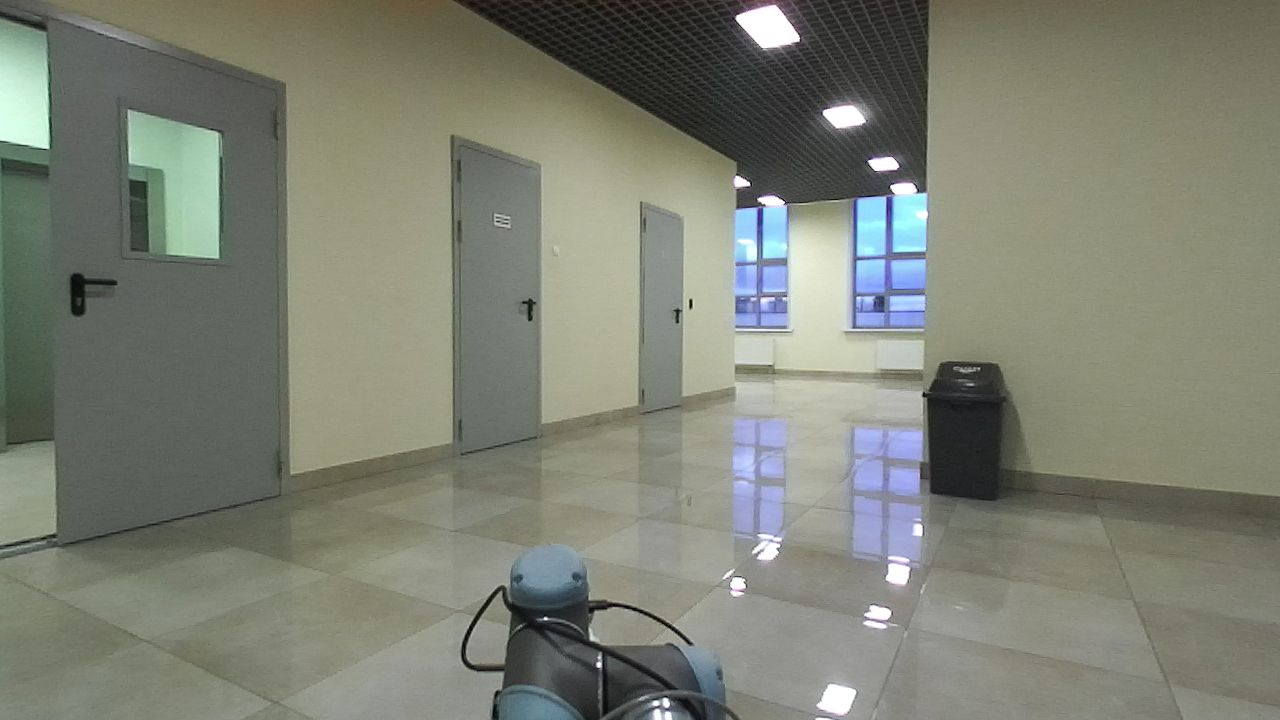

In [30]:
q_img_filename = f"floor_{query_dataset.dataset_df['floor'].iloc[sample_true_pair[0]]}/front_cam/{query_dataset.dataset_df['front_cam_ts'].iloc[sample_true_pair[0]]}.png"
db_img_filename = f"floor_{db_dataset.dataset_df['floor'].iloc[sample_true_pair[1]]}/front_cam/{db_dataset.dataset_df['front_cam_ts'].iloc[sample_true_pair[1]]}.png"
print(q_img_filename, db_img_filename)

q_img_filepath = f"{QUERY_TRACK_DIR}/{q_img_filename}"
db_img_filepath = f"{DATABASE_TRACK_DIR}/{db_img_filename}"
# print(q_img_filepath, db_img_filepath)

from IPython.display import Image

Image(q_img_filepath)

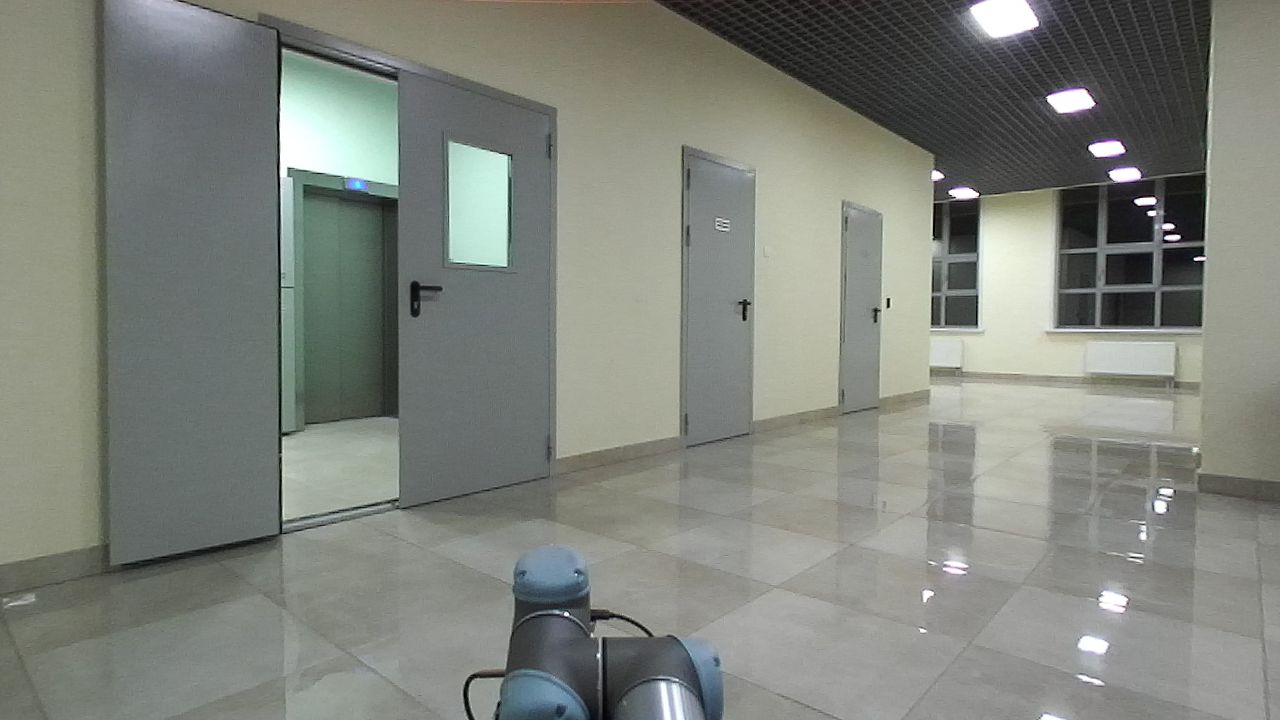

In [31]:
Image(db_img_filepath)

# false pair vis

floor_1/front_cam/1699537878397230633.png floor_3/front_cam/1698263229973756667.png


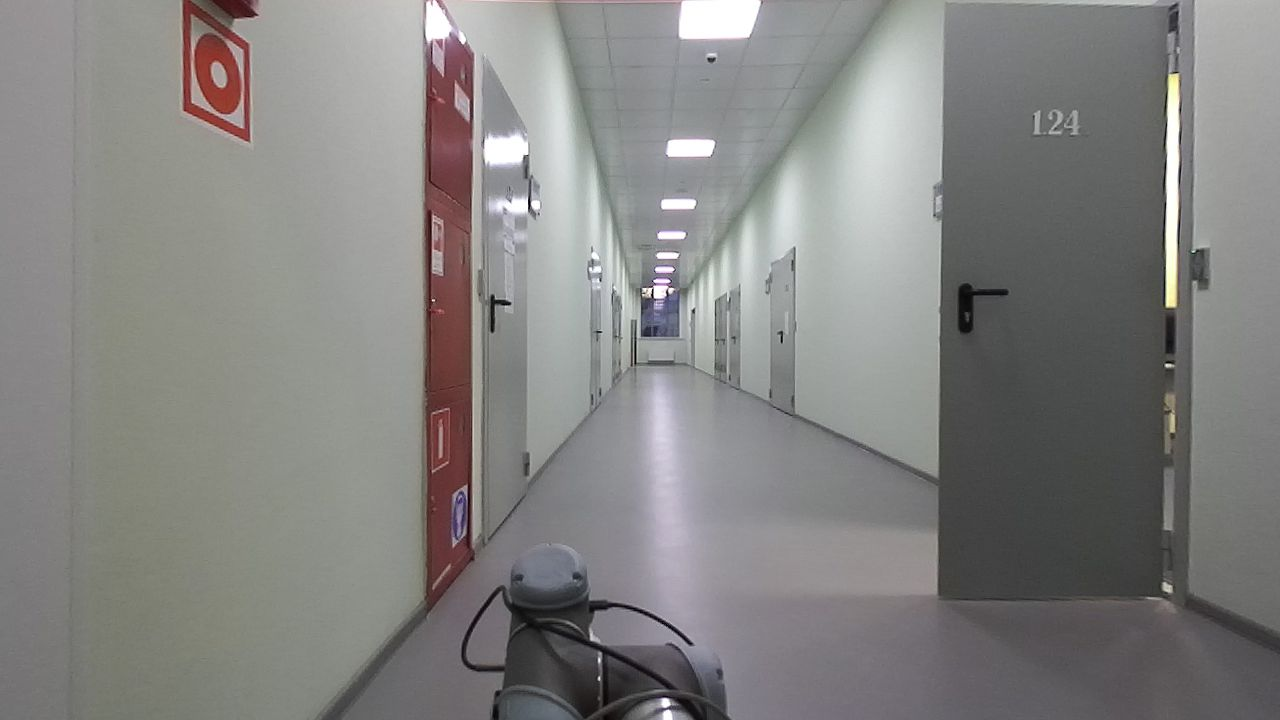

In [35]:
q_img_filename = f"floor_{query_dataset.dataset_df['floor'].iloc[sample_false_pair[0]]}/front_cam/{query_dataset.dataset_df['front_cam_ts'].iloc[sample_false_pair[0]]}.png"
db_img_filename = f"floor_{db_dataset.dataset_df['floor'].iloc[sample_false_pair[1]]}/front_cam/{db_dataset.dataset_df['front_cam_ts'].iloc[sample_false_pair[1]]}.png"
print(q_img_filename, db_img_filename)

q_img_filepath = f"{QUERY_TRACK_DIR}/{q_img_filename}"
db_img_filepath = f"{DATABASE_TRACK_DIR}/{db_img_filename}"
# print(q_img_filepath, db_img_filepath)

from IPython.display import Image

Image(q_img_filepath)

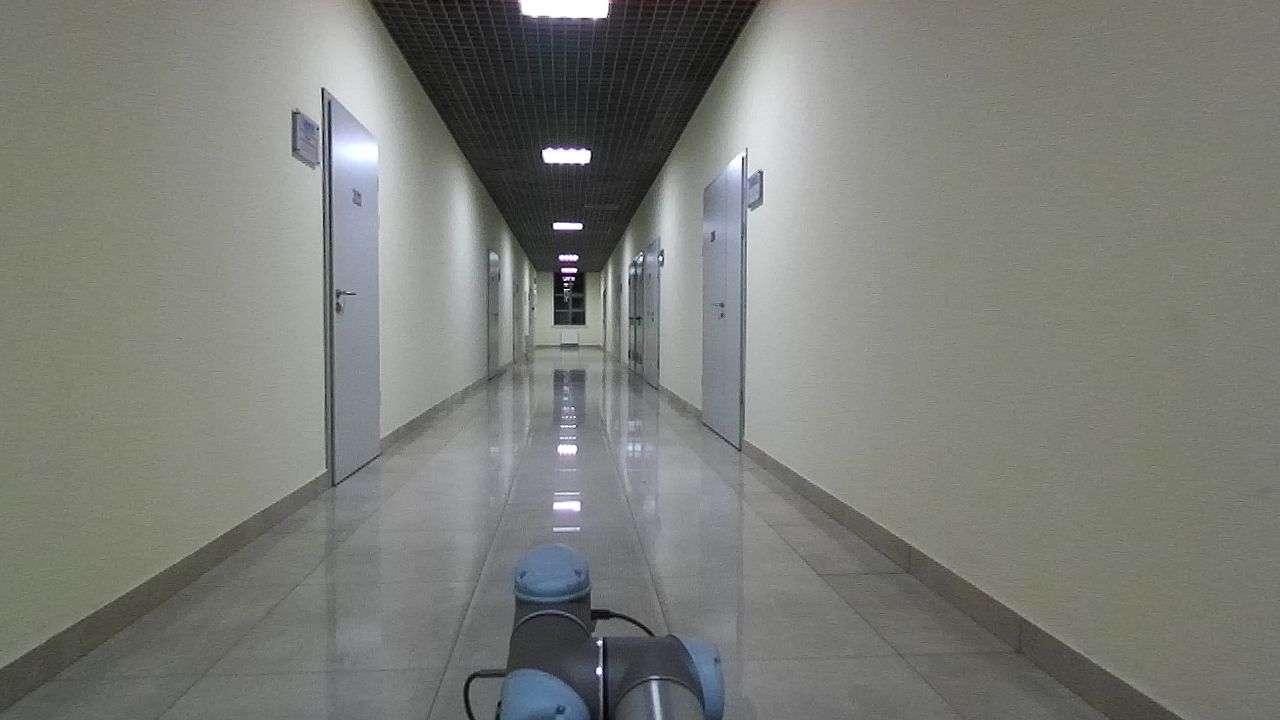

In [36]:
Image(db_img_filepath)